<a href="https://colab.research.google.com/github/HSS107048212/KeywordsMap/blob/main/KeywordsMap_V3_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

安裝所需的Python套件：Pytrends、pandas和gspread-dataframe

In [93]:
!pip install Pytrends
!pip install pandas
!pip install gspread-dataframe==3.2.1

匯入所需的Python套件和模組。

In [94]:
import pandas as pd
from pytrends.request import TrendReq
from google.colab import auth
import gspread
from google.auth import default
import time
import matplotlib.pyplot as plt
import seaborn as sns
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import urllib.parse
import pathlib

import contextlib

import requests
from pytrends.request import TrendReq

定義一個名為_TrendReq的類別，繼承自TrendReq類別，並定義GetGoogleCookie方法。

In [95]:
class _TrendReq(TrendReq):
    def GetGoogleCookie(self):
        # TODO: make sure to get rid of this dirty hack
        with _requests_get_as_post():
            return super().GetGoogleCookie()

定義一個名為_requests_get_as_post的上下文管理器，將requests.get方法替換為requests.post方法。

In [96]:
@contextlib.contextmanager
def _requests_get_as_post():
    requests.get, requests_get = requests.post, requests.get
    try:
        yield
    finally:
        requests.get = requests_get

記錄程式開始運行的時間，並建立一個_TrendReq類的實例pytrend，指定語言為英文（en-GB），時區為360。

In [97]:
startTime = time.time()
pytrend = _TrendReq(hl='en-GB', tz=360)

In [98]:
df2 = ['LeBron Raymone James Sr.','雷霸龍·瑞蒙·詹姆士一世','LeBron James', '雷霸龍·詹姆士一世', '雷霸龍·詹姆士']
d_from="2022-01-19"
d_to="2023-06-19"
geos=['TW']

定義一個空列表dataset_time用於存儲資料集，設置一個延遲時間DELAY_TIME為2秒，定義另外三個空列表df_list、keywords和geos。

In [99]:
dataset_time = []
DELAY_TIME = 2
df_list = []
keywords = []

遍歷geos列表中的元素，對每個地理位置進行相關搜尋。從df2中獲取關鍵字列表，使用pytrend.build_payload方法構建請求的參數，並進行相關搜尋。在處理過程中，如果出現錯誤，則延遲一段時間後再次嘗試。將獲得的資料加入dataset_time列表，並在資料中添加一個名為country的列。

將dataset_time中的每個字典資料轉換為pandas的DataFrame格式，並將其添加到datalist列表中。

將datalist中的每個DataFrame添加到df_list列表中。

In [100]:
for geo1 in geos:
  keywords = list(df2)

  pytrend.build_payload(kw_list=keywords, cat=0, timeframe= str(d_from + " " + d_to), geo= str(geo1))
  done = False
  while not done:
    try:
      data_time = pytrend.interest_over_time()
      done = True
      break
    except:
      time.sleep(DELAY_TIME) # delay because too many requests

  data_time['country']=geo1
  data_time = data_time.drop(labels=['isPartial'],axis='columns')
  dataset_time.append(data_time)


  datalist = []
  for i in dataset_time:
    result = pd.DataFrame(i)
    datalist.append(result)

  for i in datalist:
    df_list.append(i)

對df_list中的每個DataFrame進行處理，去除所有列中的缺失值，並將處理後的DataFrame添加到new_df_list列表中。

In [101]:
new_df_list = []

for i in df_list:
  new_i = i.dropna(axis=1, how='all')
  new_df_list.append(new_i)



對new_df_list中的每個DataFrame進行處理，過濾重複的資料，將不重複的DataFrame添加到final_df_list列表中。

In [102]:
final_df_list = None
for i in new_df_list:
  if final_df_list is None:
    final_df_list = [i]
  else:
    hasdf = False
    for j in final_df_list:
      if i.equals(j):
        hasdf = True
    if not hasdf:
      final_df_list.append(i)

對final_df_list中的每個DataFrame進行處理，重設索引，並將date列設置為新的索引，然後將處理後的DataFrame添加到new_final列表中。

In [103]:
new_final = []
for i in final_df_list:
  new_i = i.reset_index().set_index(['date'])
  new_final.append(new_i)

將new_final中的所有DataFrame合併為一個大的DataFrame，並將date列轉換為日期格式，然後將其設置為索引。

In [107]:
big_df = pd.concat(new_final).reset_index()
big_df['date'] = pd.to_datetime(big_df['date']).dt.date

#big_df = big_df.set_index(['date'])

In [108]:
#輸出成果的dataframe
big_df

,date,LeBron Raymone James Sr.,雷霸龍·瑞蒙·詹姆士一世,LeBron James,雷霸龍·詹姆士一世,雷霸龍·詹姆士,country
0,2022-01-23,0,0,16,0,1,TW
1,2022-01-30,0,0,12,0,1,TW
2,2022-02-06,0,0,13,0,0,TW
3,2022-02-13,0,0,15,0,0,TW
4,2022-02-20,0,0,17,0,0,TW
...,...,...,...,...,...,...,...
69,2023-05-21,0,0,27,0,0,TW
70,2023-05-28,0,0,12,0,1,TW
71,2023-06-04,0,0,11,0,0,TW
72,2023-06-11,0,0,11,0,0,TW


In [115]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_line_chart(df):
    # 將 'date' 欄位轉換為日期型別
    df['date'] = pd.to_datetime(df['date'])

    # 設定圖形大小
    plt.figure(figsize=(10, 6))

    # 繪製折線圖
    for column in df.columns[1:-1]:
        plt.plot(df['date'], df[column], marker='o', label=column)

    # 設定標籤和標題
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Line Chart')

    # 設定圖例
    plt.legend()

    # 顯示圖形
    plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38647 (\N{CJK UNIFIED IDEOGRAPH-96F7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38712 (\N{CJK UNIFIED IDEOGRAPH-9738}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40845 (\N{CJK UNIFIED IDEOGRAPH-9F8D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29790 (\N{CJK UNIFIED IDEOGRAPH-745E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 33945 (\N{CJK UNIFIED IDEOGRAPH-8499}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

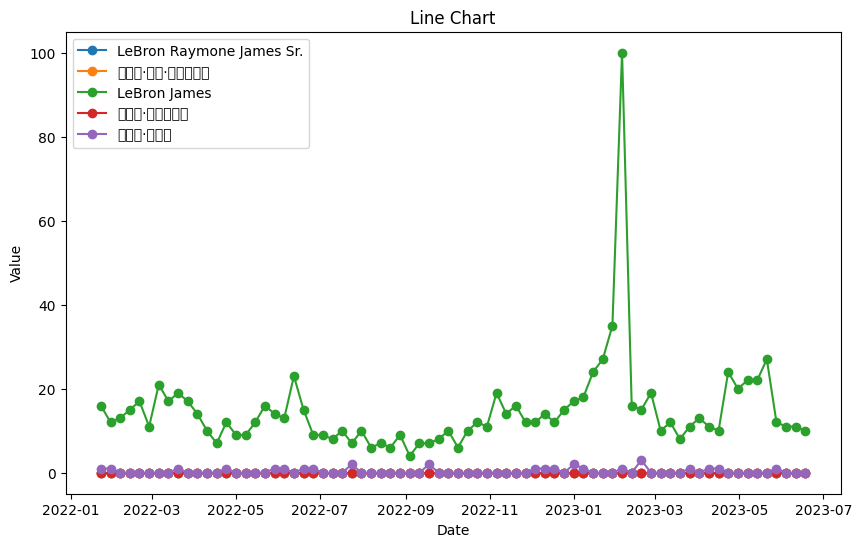

In [116]:
plot_line_chart(big_df)